In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import torch
from torch import nn

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

import pickle
import re

Load data

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv('../data/notebooks/features_selected.csv')
df

,year,fight_time_avg_diff,days_since_debut_diff,win_pct_before_diff,sig_strikes_landed_per_minute_diff,knockdown_avg_diff,takedowns_avg_diff,days_since_last_win_diff,avg_time_diff,avg_body_attempts_diff,losses_before_diff,takedowns_ema_diff,avg_ground_attempts_diff,avg_body_strikes_diff,avg_takedown_attempts_diff,avg_takedowns_diff,avg_sub_attempts_diff,control_time_roll_5_diff,takedowns_success_rate_roll_5_diff,takedown_attempts_ema_diff,avg_ground_strikes_diff,avg_clinch_strikes_diff,avg_clinch_attempts_diff,weight_diff,avg_rounds_diff,avg_head_strikes_diff,avg_leg_attempts_diff,avg_leg_strikes_diff,avg_knockdowns_diff,total_strikes_roll_5_diff,avg_distance_diff,head_strikes_ema_diff,knockdowns_ema_diff,submission_avg_diff,takedowns_roll_5_diff,avg_total_strikes_diff,avg_distance_attempts_diff,leg_reach_diff,avg_head_attempts_diff,total_strikes_ema_diff,takedown_attempts_roll_5_diff,reach_diff,total_strikes_attempts_roll_5_diff,head_attempts_ema_diff,avg_sig_strikes_diff,sig_attempts_ema_diff,avg_sig_attempts_diff,total_fights_before_diff,sig_attempts_roll_5_diff,sig_strikes_roll_5_diff,avg_total_strikes_attempts_diff,sig_strikes_ema_diff,total_strikes_attempts_ema_diff,wins_before_diff,height_diff,month,sig_strikes_absorbed_per_minute_diff,win_streak_diff,knockdowns_roll_5_diff,fights_last_365_days_diff,wins_last_365_days_diff,lose_streak_diff,winner
0,1994,-630.0,-280,0.000,-1.0,0.00,0.00,0.0,-119.214286,-1.428571,0,0.849900,-1.857143,-0.714286,1.571429,0.928571,-0.285714,0.0,0.400000,0.733449,-1.428571,-1.714286,-2.857143,-8.494553,0.000000,-2.285714,-1.571429,-0.714286,0.000000,-17.800000,-0.571429,-3.448263,0.000000,-0.76,1.100000,-30.000000,-2.142857,-0.597872,-3.857143,-35.165021,1.600000,-3.212908,-22.000000,-6.478263,-3.714286,-10.764280,-6.857143,-5,-8.000000,-4.000000,-33.571429,-5.500982,-40.963617,-5,-2.859459,12,-1.0,-5,0.000000,-5,-5,0,1
1,1995,-333.0,-98,-0.167,-1.0,-0.31,-0.94,-210.0,-7.166667,-2.333333,1,0.072030,0.333333,-2.500000,0.166667,0.166667,0.166667,0.0,0.130000,-0.011880,-1.833333,-1.333333,-1.166667,-37.494553,0.000000,-0.333333,-0.333333,-0.333333,0.000000,6.100000,0.000000,-0.751400,0.000000,-2.52,0.200000,3.166667,-0.500000,-1.997872,1.333333,2.675300,0.300000,-3.012908,14.300000,1.137300,-3.166667,-1.568700,-1.333333,4,-0.300000,-2.600000,9.666667,-3.604400,9.375700,3,-2.859459,7,-4.0,1,0.000000,4,3,0,1
2,1995,0.0,0,-0.083,0.0,0.00,0.00,98.0,-258.166667,0.000000,0,0.700000,10.333333,0.000000,-0.333333,0.666667,-1.500000,0.0,0.666667,-0.543000,6.666667,0.416667,1.416667,0.000000,0.000000,6.333333,0.000000,0.000000,0.000000,1.000000,-0.750000,6.960000,0.000000,0.00,0.666667,1.000000,-1.916667,0.000000,9.833333,-2.400000,-0.333333,0.000000,3.916667,10.350000,6.333333,10.350000,9.833333,-1,9.833333,6.333333,3.916667,6.960000,0.000000,-1,0.000000,7,0.0,-2,0.000000,-1,-1,1,1
3,1995,0.0,56,-0.250,0.0,0.00,0.00,0.0,-399.750000,-0.250000,1,0.300000,-0.500000,-0.500000,0.000000,0.000000,-2.000000,0.0,0.333333,0.300000,0.000000,1.000000,2.250000,0.000000,0.000000,2.250000,-1.250000,-0.500000,0.250000,-1.666667,0.250000,3.030000,0.490000,0.00,0.333333,9.250000,2.000000,0.000000,5.250000,-1.400000,0.333333,0.000000,-2.333333,8.420000,1.250000,5.100000,3.750000,2,2.000000,-0.333333,11.250000,0.730000,-0.030000,1,0.000000,9,0.0,0,0.333333,2,1,0,1
4,1995,0.0,-154,0.200,0.0,0.00,0.00,0.0,169.500000,0.500000,-1,0.300000,4.500000,0.500000,-0.250000,0.500000,0.100000,0.0,0.333333,-0.870100,3.000000,0.550000,0.400000,0.000000,0.000000,3.200000,9.750000,6.750000,0.250000,11.733333,6.900000,1.840000,0.210000,0.00,0.333333,8.900000,11.950000,0.000000,6.600000,5.750000,-0.666667,0.000000,21.466667,3.830000,10.450000,13.420000,16.850000,-2,19.933333,11.866667,16.550000,8.350000,12.570000,-1,0.000000,12,0.0,0,0.333333,-3,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Split data

In [4]:
X = df.drop('winner', axis=1)
y = df['winner']

print(X.shape, y.shape)

(4590, 62) (4590,)


In [5]:
# Split chronologically on the sorted data
split_idx = int(len(df) * 0.8)
train_indices = df.index[:split_idx]
test_indices = df.index[split_idx:]

# Split features and target
X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

In [6]:
print(X_train.shape, X_test.shape)

(3672, 62) (918, 62)


Scale data

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Note: only transform, don't fit

# Save the fitted scaler
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Convert back to DataFrames if needed
X_train = pd.DataFrame(X_train, columns=X.columns, index=train_indices)
X_test = pd.DataFrame(X_test, columns=X.columns, index=test_indices)

In [8]:
X_train

,year,fight_time_avg_diff,days_since_debut_diff,win_pct_before_diff,sig_strikes_landed_per_minute_diff,knockdown_avg_diff,takedowns_avg_diff,days_since_last_win_diff,avg_time_diff,avg_body_attempts_diff,losses_before_diff,takedowns_ema_diff,avg_ground_attempts_diff,avg_body_strikes_diff,avg_takedown_attempts_diff,avg_takedowns_diff,avg_sub_attempts_diff,control_time_roll_5_diff,takedowns_success_rate_roll_5_diff,takedown_attempts_ema_diff,avg_ground_strikes_diff,avg_clinch_strikes_diff,avg_clinch_attempts_diff,weight_diff,avg_rounds_diff,avg_head_strikes_diff,avg_leg_attempts_diff,avg_leg_strikes_diff,avg_knockdowns_diff,total_strikes_roll_5_diff,avg_distance_diff,head_strikes_ema_diff,knockdowns_ema_diff,submission_avg_diff,takedowns_roll_5_diff,avg_total_strikes_diff,avg_distance_attempts_diff,leg_reach_diff,avg_head_attempts_diff,total_strikes_ema_diff,takedown_attempts_roll_5_diff,reach_diff,total_strikes_attempts_roll_5_diff,head_attempts_ema_diff,avg_sig_strikes_diff,sig_attempts_ema_diff,avg_sig_attempts_diff,total_fights_before_diff,sig_attempts_roll_5_diff,sig_strikes_roll_5_diff,avg_total_strikes_attempts_diff,sig_strikes_ema_diff,total_strikes_attempts_ema_diff,wins_before_diff,height_diff,month,sig_strikes_absorbed_per_minute_diff,win_streak_diff,knockdowns_roll_5_diff,fights_last_365_days_diff,wins_last_365_days_diff,lose_streak_diff
0,-4.293334,-3.372698,0.008134,0.106483,-0.662299,-0.009017,0.064209,-0.058198,-1.793822,-0.140076,0.171814,0.591337,-0.108566,-0.095455,0.536673,0.693143,-0.406840,0.031657,1.410381,0.263464,-0.129173,-0.295537,-0.358936,-0.622110,0.078359,-0.117460,-0.155341,-0.070590,0.032268,-0.449632,-0.003915,-0.132954,0.007525,-0.895217,0.731895,-0.917975,-0.018351,-0.245926,-0.061185,-0.926626,0.499644,-0.977501,-0.281631,-0.070757,-0.130900,-0.114070,-0.099812,-0.476808,-0.065938,-0.085004,-0.566540,-0.143789,-0.573557,-0.866457,-1.155400,1.516541,-0.802683,-2.290593,0.017381,-4.320828,-4.688156,0.095808
1,-4.094531,-1.742454,0.143218,-0.590193,-0.662299,-0.650760,-0.532536,-0.171959,-0.101784,-0.244456,0.510098,0.086700,0.099516,-0.381840,0.100778,0.173451,0.241572,0.031657,0.469451,0.044792,-0.185533,-0.231306,-0.150421,-2.912916,0.078359,0.014870,0.006637,-0.007405,0.032268,0.215129,0.026600,0.022952,0.007525,-3.002938,0.158490,0.127446,0.016391,-0.897135,0.064884,0.130313,0.124675,-0.914601,0.280088,0.090120,-0.104869,0.047565,0.012235,0.878214,0.068436,-0.027825,0.203516,-0.066700,0.211924,1.019792,-1.155400,0.051931,-2.945258,0.487626,0.017381,3.485575,2.732863,0.095808
2,-4.094531,0.085396,0.215956,-0.239769,0.028979,-0.009017,0.064209,-0.005109,-3.892151,0.024735,0.171814,0.494090,1.049457,0.019099,-0.054371,0.514499,-2.147312,0.031657,2.339693,-0.111033,0.998037,0.063759,0.168226,0.048902,0.078359,0.466726,0.050247,0.047881,0.032268,0.073276,-0.013451,0.468751,0.007525,0.014935,0.455811,0.059152,-0.013568,0.032174,0.271335,-0.011448,-0.058002,0.032962,0.119413,0.284736,0.346708,0.257066,0.238746,0.125424,0.245276,0.337028,0.101110,0.362699,0.065628,0.076667,-0.007146,0.051931,-0.088492,-0.901484,0.017381,-0.851316,-0.977646,1.124481
3,-4.094531,0.085396,0.257521,-0.936445,0.028979,-0.009017,0.064209,-0.058198,-6.030210,-0.004107,0.510098,0.234594,0.020354,-0.061089,0.049062,0.059768,-2.863978,0.031657,1.178052,0.136294,0.069747,0.162114,0.271015,0.048902,0.078359,0.189964,-0.113289,-0.035049,0.705913,-0.000895,0.039950,0.241556,1.186857,0.014935,0.243439,0.319194,0.069259,0.032174,0.160013,0.016483,0.134290,0.032962,0.022698,0.243965,0.105075,0.164784,0.115348,0.577098,0.108574,0.064750,0.231714,0.109475,0.065160,0.548230,-0.007146,0.637775,-0.088492,0.024589,0.820675,1.750819,0.877608,0.095808
4,-4.094531,0.085396,0.101654,0.940825,0.028979,-0.009017,0.064209,-0.058198,2.566071,0.082419,-0.166470,0.234594,0.495325,0.099287,-0.028513,0.400816,0.146016,0.031657,1.178052,-0.207001,0.487477,0.086240,0.042823,0.048902,0.078359,0.254353,1.325829,1.167435,0.705913,0.371816,0.395066,0.17276

Find best models using GridSearch

In [9]:
def tune_models(model_param_list, X_train, y_train, scoring='accuracy', cv=5):
    """
    Performs GridSearchCV for each model and parameter grid.

    Args:
        model_param_list (list): List of tuples: (model_name, model_instance, param_grid)
        X_train (DataFrame): Training features
        y_train (Series or array): Training labels
        scoring (str): Scoring metric for GridSearchCV (default: 'accuracy')
        cv (int): Number of cross-validation folds (default: 5)

    Returns:
        dict: model_name -> best GridSearchCV result
    """

    best_models = {}

    start_time = time.time()

    for name, model, param_grid in model_param_list:
        start_iteration_time = time.time()
        grid = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)

        print(f"Best score for {name}: {grid.best_score_:.4f}")
        print(f"Best parameters for {name}: {grid.best_params_}")
        end_iteration_time = time.time()
        print(f"Tuning completed in {end_iteration_time - start_iteration_time:.2f} seconds.")    

        best_models[name] = grid
    
    end_time = time.time()
    print(f"Overall tuning completed in {end_time - start_time:.2f} seconds.")

    return best_models

Parameters for each model

In [10]:
model_param_list = [
    (
        "LogisticRegression",
        LogisticRegression(),
        [
                # L2 penalty
            {
                'penalty': ['l2'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
            },
                # L1 penalty
            {
                'penalty': ['l1'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'saga']
            },
                # ElasticNet penalty
            {
                'penalty': ['elasticnet'],
                'C': [0.01, 0.1, 1, 10],
                'solver': ['saga'],
                'l1_ratio': [0.0, 0.5, 1.0]
            },
                # No penalty
            {
                'penalty': [None],
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
            }
        ]
    ),
    (
        "SVC",
        SVC(),
        {
            'C': [0.1, 1],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale'],
            'degree': [3] 
        }
    ),
    (
        "SGDClassifier",
        SGDClassifier(),
        {
            'alpha': [0.0001, 0.001, 0.01],
            'loss': ['hinge', 'log_loss', 'squared_hinge', 'perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'l1_ratio': [0.15, 0.5, 0.85],  # only for elasticnet
            'max_iter': [1000, 2000, 5000]
        }  
    ),
    (
        "GaussianNB",
        GaussianNB(),
        {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    ),
    (
        "KNeighborsClassifier",
        KNeighborsClassifier(),
        {
        'n_neighbors': [3, 5, 7, 9, 12, 15],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],  # 1=Manhattan, 2=Euclidean
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40]
        }
    ),
    (
        "DecisionTreeClassifier",
        DecisionTreeClassifier(),
        {
            'criterion': ['gini'],
            'max_depth': [None, 6, 8, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 'log2']
        }
    ),
    (
        "RandomForestClassifier",
        RandomForestClassifier(),
        {
            'n_estimators': [100, 200],
            'criterion': ['gini'],
            'max_depth': [None, 8, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    (
        "AdaBoostClassifier",
        AdaBoostClassifier(),
        {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        }
    ),
    (
        "GradientBoostingClassifier",
        GradientBoostingClassifier(),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'subsample': [0.8, 1.0],
            'max_features': ['sqrt', 'log2']
        }
    ),
    (
        "XGBClassifier",
        XGBClassifier(),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 0.1],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [1, 1.5]
        }
    )
]

In [11]:
best_models = tune_models(model_param_list, X_train, y_train, scoring='accuracy', cv=5)

Best score for LogisticRegression: 0.6609
Best parameters for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Tuning completed in 11.06 seconds.
Best score for SVC: 0.6618
Best parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Tuning completed in 6.06 seconds.
Best score for SGDClassifier: 0.6672
Best parameters for SGDClassifier: {'alpha': 0.01, 'l1_ratio': 0.15, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l1'}
Tuning completed in 64.36 seconds.
Best score for GaussianNB: 0.6184
Best parameters for GaussianNB: {'var_smoothing': 1e-09}
Tuning completed in 0.21 seconds.
Best score for KNeighborsClassifier: 0.6215
Best parameters for KNeighborsClassifier: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Tuning completed in 39.38 seconds.
Best score for DecisionTreeClassifier: 0.6228
Best parameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_s

Neural Network

In [12]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Is CUDA supported by this system? True
CUDA version: 11.8


'cuda'

Convert X and y to numpy arrays for calculations

In [13]:
X_train_torch = torch.from_numpy(X_train.to_numpy()).type(torch.float)
y_train_torch = torch.from_numpy(y_train.to_numpy()).type(torch.float)
X_test_torch = torch.from_numpy(X_test.to_numpy()).type(torch.float)
y_test_torch = torch.from_numpy(y_test.to_numpy()).type(torch.float)

# View the first five samples
X_train_torch[:5], y_train_torch[:5]

(tensor([[-4.2933e+00, -3.3727e+00,  8.1335e-03,  1.0648e-01, -6.6230e-01,
          -9.0169e-03,  6.4209e-02, -5.8198e-02, -1.7938e+00, -1.4008e-01,
           1.7181e-01,  5.9134e-01, -1.0857e-01, -9.5455e-02,  5.3667e-01,
           6.9314e-01, -4.0684e-01,  3.1657e-02,  1.4104e+00,  2.6346e-01,
          -1.2917e-01, -2.9554e-01, -3.5894e-01, -6.2211e-01,  7.8359e-02,
          -1.1746e-01, -1.5534e-01, -7.0590e-02,  3.2268e-02, -4.4963e-01,
          -3.9150e-03, -1.3295e-01,  7.5254e-03, -8.9522e-01,  7.3189e-01,
          -9.1797e-01, -1.8351e-02, -2.4593e-01, -6.1185e-02, -9.2663e-01,
           4.9964e-01, -9.7750e-01, -2.8163e-01, -7.0757e-02, -1.3090e-01,
          -1.1407e-01, -9.9812e-02, -4.7681e-01, -6.5938e-02, -8.5004e-02,
          -5.6654e-01, -1.4379e-01, -5.7356e-01, -8.6646e-01, -1.1554e+00,
           1.5165e+00, -8.0268e-01, -2.2906e+00,  1.7381e-02, -4.3208e+00,
          -4.6882e+00,  9.5808e-02],
         [-4.0945e+00, -1.7425e+00,  1.4322e-01, -5.9019e-01, -

In [14]:
print(X_train_torch.shape)
print(y_train_torch.shape)

torch.Size([3672, 62])
torch.Size([3672])


In [15]:
class Deep(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.network(x)
    
pytorch_model = Deep(input_dim=X_train_torch.shape[1]).to(device)
pytorch_model

Deep(
  (network): Sequential(
    (0): Linear(in_features=62, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [16]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10)

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
epochs = 60

X_train_torch, y_train_torch = X_train_torch.to(device), y_train_torch.to(device)
X_test_torch, y_test_torch = X_test_torch.to(device), y_test_torch.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):

    pytorch_model.train()

    # 1 Forward pass
    y_logits = pytorch_model(X_train_torch).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #2 Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train_torch)

    acc = accuracy_fn(y_true = y_train_torch, y_pred=y_pred)

    #3 Optimizer
    optimizer.zero_grad()

    #4 Loss backwards
    loss.backward()

    #5 Optimizer step
    optimizer.step()

    
    # Save training metrics
    train_losses.append(loss.item())
    train_accuracies.append(acc)

    # Testing
    pytorch_model.eval()
    with torch.inference_mode():
        #1 Forward pass
        test_logits = pytorch_model(X_test_torch).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #2 Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test_torch)
        scheduler.step(test_loss)
        
        test_acc = accuracy_fn(y_true=y_test_torch,
                                y_pred=test_pred)
        
        # Save test metrics
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72003, Accuracy: 37.72% | Test loss: 0.70616, Test acc: 43.57%
Epoch: 10 | Loss: 0.66325, Accuracy: 61.90% | Test loss: 0.68712, Test acc: 54.47%
Epoch: 20 | Loss: 0.61047, Accuracy: 63.21% | Test loss: 0.65308, Test acc: 60.02%
Epoch: 30 | Loss: 0.57706, Accuracy: 67.43% | Test loss: 0.64911, Test acc: 65.36%
Epoch: 40 | Loss: 0.55122, Accuracy: 70.83% | Test loss: 0.64946, Test acc: 66.56%
Epoch: 50 | Loss: 0.53448, Accuracy: 72.22% | Test loss: 0.65267, Test acc: 65.47%


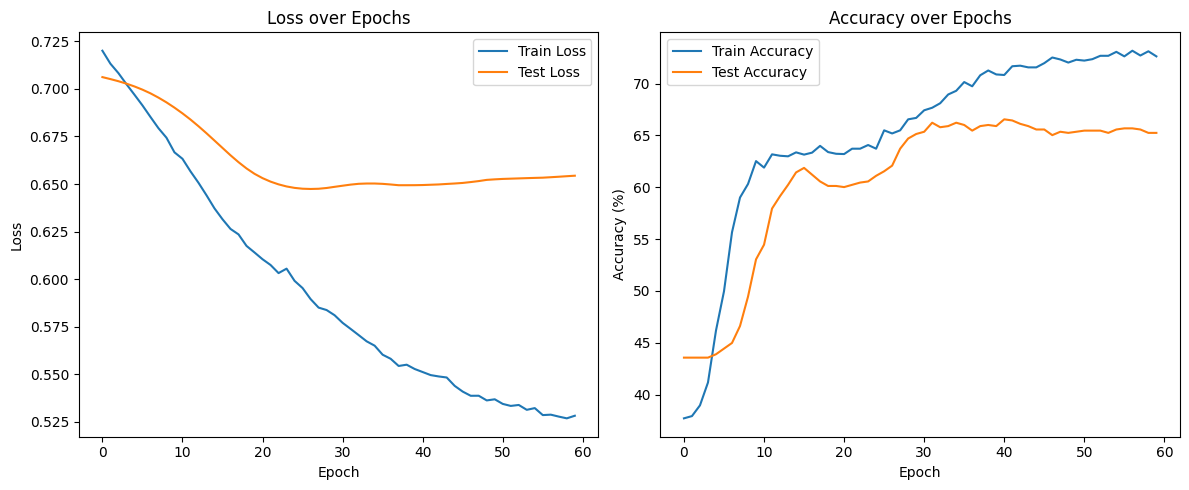

In [19]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
def evaluate(model, X, y):
    model.eval()
    with torch.inference_mode():
        logits = model(X).squeeze()
        preds = torch.round(torch.sigmoid(logits))
        loss = loss_fn(logits, y)
        acc = accuracy_fn(y_true=y, y_pred=preds)
    return loss.item(), acc

test_loss, test_acc = evaluate(pytorch_model, X_test_torch, y_test_torch)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6544, Test Accuracy: 65.25%


In [21]:
# Move data back to CPU if it's on GPU

y_true1 = y_test_torch.cpu().numpy()
y_scores1 = pytorch_model(X_test_torch).squeeze().detach().cpu()
y_pred1 = torch.round(torch.sigmoid(y_scores1)).numpy()

# Print classification report
print(classification_report(y_true1, y_pred1))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true1, y_pred1))


              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61       400
         1.0       0.70      0.68      0.69       518

    accuracy                           0.65       918
   macro avg       0.65      0.65      0.65       918
weighted avg       0.65      0.65      0.65       918

Confusion Matrix:
[[245 155]
 [164 354]]


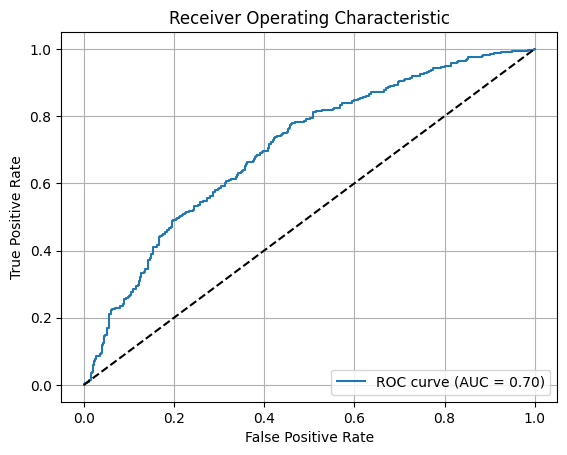

In [22]:
fpr, tpr, thresholds = roc_curve(y_true1, y_scores1.numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Evaluate Models

In [23]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics on test
    metrics = {
        'Model': name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'F1': f1_score(y_test, y_test_pred, zero_division=0)
    }

    # Overfitting check (gap between train/test accuracy)
    metrics['Overfit Gap'] = metrics['Train Accuracy'] - metrics['Test Accuracy']

    return metrics

In [24]:
def evaluate_pytorch_model(model, X_train, y_train, X_test, y_test):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Train predictions
        y_train_logits = model(X_train.to(device)).squeeze()
        y_train_probs = torch.sigmoid(y_train_logits)
        y_train_pred = torch.round(y_train_probs).cpu().numpy()
        y_train_true = y_train.cpu().numpy()

        # Test predictions
        y_test_logits = model(X_test.to(device)).squeeze()
        y_test_probs = torch.sigmoid(y_test_logits)
        y_test_pred = torch.round(y_test_probs).cpu().numpy()
        y_test_true = y_test.cpu().numpy()

    metrics = {
        'Model': 'Neural Network',
        'Train Accuracy': accuracy_score(y_train_true, y_train_pred),
        'Test Accuracy': accuracy_score(y_test_true, y_test_pred),
        'Precision': precision_score(y_test_true, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test_true, y_test_pred, zero_division=0),
        'F1': f1_score(y_test_true, y_test_pred, zero_division=0),
        'Overfit Gap': accuracy_score(y_train_true, y_train_pred) - accuracy_score(y_test_true, y_test_pred)
    }

    return metrics



In [25]:
# Ensemble Prediction Function
def ensemble_predict(best_models_dict, pytorch_model, X, X_torch=None, selected_models=None, include_pytorch=True):
    """
    Make ensemble predictions using selected models
    
    Parameters:
    - selected_models: list of model names to include (e.g., ['RandomForest', 'XGBoost'])
    - include_pytorch: whether to include the pytorch model
    """
    predictions = []
    
    # Get predictions from selected sklearn models
    if selected_models is None:
        # Use all models if none specified
        models_to_use = best_models_dict.items()
    else:
        # Filter to only selected models
        models_to_use = [(name, grid) for name, grid in best_models_dict.items() if name in selected_models]
    
    for name, grid in models_to_use:
        best_model = grid.best_estimator_
        pred = best_model.predict(X)
        predictions.append(pred)
    
    # Get predictions from PyTorch model if requested and available
    if include_pytorch and pytorch_model is not None and X_torch is not None:
        pytorch_model.eval()
        device = next(pytorch_model.parameters()).device
        with torch.no_grad():
            logits = pytorch_model(X_torch.to(device)).squeeze()
            probs = torch.sigmoid(logits)
            nn_pred = torch.round(probs).cpu().numpy()
            predictions.append(nn_pred)
    
    # Majority voting
    if predictions:
        predictions_array = np.array(predictions)
        ensemble_pred = np.round(np.mean(predictions_array, axis=0))
        return ensemble_pred.astype(int)
    else:
        raise ValueError("No models available for ensemble")

# Ensemble Evaluation Function
def evaluate_ensemble(best_models_dict, pytorch_model, X_train, y_train, X_test, y_test, 
                    X_train_torch=None, y_train_torch=None, X_test_torch=None, y_test_torch=None,
                    selected_models=None, include_pytorch=True):
    """
    Evaluate ensemble using selected models
    
    Parameters:
    - selected_models: list of model names to include (e.g., ['RandomForest', 'XGBoost'])
    - include_pytorch: whether to include the pytorch model
    """
    # Get predictions
    y_train_pred = ensemble_predict(best_models_dict, pytorch_model, X_train, X_train_torch, 
                                selected_models, include_pytorch)
    y_test_pred = ensemble_predict(best_models_dict, pytorch_model, X_test, X_test_torch, 
                                selected_models, include_pytorch)
    
    # Convert torch tensors to numpy if needed
    if hasattr(y_train, 'cpu'):
        y_train_np = y_train.cpu().numpy()
    else:
        y_train_np = y_train
        
    if hasattr(y_test, 'cpu'):
        y_test_np = y_test.cpu().numpy()
    else:
        y_test_np = y_test
    
    # Calculate metrics
    metrics = {
        'Model': 'Ensemble',
        'Train Accuracy': accuracy_score(y_train_np, y_train_pred),
        'Test Accuracy': accuracy_score(y_test_np, y_test_pred),
        'Precision': precision_score(y_test_np, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test_np, y_test_pred, zero_division=0),
        'F1': f1_score(y_test_np, y_test_pred, zero_division=0)
    }
    
    # Overfitting check
    metrics['Overfit Gap'] = metrics['Train Accuracy'] - metrics['Test Accuracy']
    
    return metrics

# Cell 3: Add Ensemble to Your Existing Results
results = []
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    metrics = evaluate_model(name, best_model, X_train, y_train, X_test, y_test)
    results.append(metrics)

nn_metrics = evaluate_pytorch_model(pytorch_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
results.append(nn_metrics)

# CHOOSE YOUR MODELS FOR ENSEMBLE
# Option 1: Use all models
# ensemble_metrics = evaluate_ensemble(best_models, pytorch_model, 
#                                    X_train, y_train, X_test, y_test,
#                                    X_train_torch, y_train_torch, X_test_torch, y_test_torch)

# Option 2: Select specific sklearn models + pytorch
selected_sklearn_models = ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'SVC','SGDClassifier', 
            'DecisionTreeClassifier', 'GaussianNB', 'KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']  # Add your model names here
ensemble_metrics = evaluate_ensemble(best_models, pytorch_model, 
                                X_train, y_train, X_test, y_test,
                                X_train_torch, y_train_torch, X_test_torch, y_test_torch,
                                selected_models=selected_sklearn_models, include_pytorch=True)

# Option 3: Only sklearn models (no pytorch)
# selected_sklearn_models = ['RandomForestClassifier', 'XGBClassifier', 'LogisticRegression']
# ensemble_metrics = evaluate_ensemble(best_models, pytorch_model, 
#                                    X_train, y_train, X_test, y_test,
#                                    X_train_torch, y_train_torch, X_test_torch, y_test_torch,
#                                    selected_models=selected_sklearn_models, include_pytorch=False)

In [26]:
results = []
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    metrics = evaluate_model(name, best_model, X_train, y_train, X_test, y_test)
    results.append(metrics)

nn_metrics = evaluate_pytorch_model(pytorch_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
results.append(nn_metrics)

selected_sklearn_models = ['LogisticRegression', 'RandomForestClassifier', 'SVC','SGDClassifier', 'GradientBoostingClassifier']
ensemble_metrics = evaluate_ensemble(best_models, pytorch_model, 
                                X_train, y_train, X_test, y_test,
                                X_train_torch, y_train_torch, X_test_torch, y_test_torch,
                                selected_models=selected_sklearn_models, include_pytorch=True)
results.append(ensemble_metrics)

results_df = pd.DataFrame(results)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
print("Models in ensemble:", selected_sklearn_models + (['Neural Network'] if True else []))
results_df

Models in ensemble: ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'SGDClassifier', 'GradientBoostingClassifier', 'Neural Network']


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1,Overfit Gap
11,Ensemble,0.720861,0.679739,0.738298,0.669884,0.702429,0.041122
0,LogisticRegression,0.697440,0.673203,0.759524,0.615830,0.680171,0.024237
2,SGDClassifier,0.689815,0.673203,0.729958,0.667954,0.697581,0.016612
1,SVC,0.700980,0.672113,0.755294,0.619691,0.680806,0.028867
10,Neural Network,0.733660,0.652505,0.695481,0.683398,0.689387,0.081155
6,RandomForestClassifier,0.821351,0.618736,0.612299,0.884170,0.723539,0.202614
8,GradientBoostingClassifier,0.680283,0.605664,0.598237,0.916988,0.724085,0.074619
3,GaussianNB,0.632353,0.583878,0.639344,0.602317,0.620278,0.048475
9,XGBClassifier,0.650599,0.582789,0.579132,0.953668,0.720642,0.067810
4,KNeighborsClassifier,0.699074,0.578431,0.602504,0.743243,0.665514,0.120643


Plot Confusion Matrix

In [27]:
accuracies = []

# Collect test accuracy for each sklearn model
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((name, best_model, acc))

# Add PyTorch model
pytorch_model.eval()
with torch.no_grad():
    y_test_logits = pytorch_model(X_test_torch).squeeze()
    y_test_probs = torch.sigmoid(y_test_logits)
    y_test_pred = torch.round(y_test_probs).cpu().numpy()
    y_test_true = y_test_torch.cpu().numpy()
    acc = accuracy_score(y_test_true, y_test_pred)
    accuracies.append(("Neural Network", pytorch_model, acc))

# Add Ensemble model
selected_sklearn_models = ['RandomForestClassifier', 'XGBClassifier', 'GradientBoostingClassifier']  # Adjust these names
ensemble_pred = ensemble_predict(best_models, pytorch_model, X_test, X_test_torch, 
                            selected_models=selected_sklearn_models, include_pytorch=True)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
accuracies.append(("Ensemble", "ensemble", ensemble_acc))

# Sort by accuracy (descending)
accuracies.sort(key=lambda x: x[2], reverse=True)

def plot_all_confusion_matrices(accuracies, X_test, y_test, X_test_torch, y_test_torch, cols=3):
    rows = math.ceil(len(accuracies) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # flatten so we can index easily
    
    for idx, (name, model, acc) in enumerate(accuracies):
        ax = axes[idx]
        
        if name == "Neural Network":
            # PyTorch predictions
            model.eval()
            with torch.no_grad():
                y_test_logits = model(X_test_torch).squeeze()
                y_test_probs = torch.sigmoid(y_test_logits)
                y_test_pred = torch.round(y_test_probs).cpu().numpy()
                y_test_true = y_test_torch.cpu().numpy()
            cm = confusion_matrix(y_test_true, y_test_pred)
            
        elif name == "Ensemble":
            # Ensemble predictions
            y_test_pred = ensemble_predict(best_models, pytorch_model, X_test, X_test_torch, 
                                        selected_models=selected_sklearn_models, include_pytorch=True)
            cm = confusion_matrix(y_test, y_test_pred)
            
        else:
            # Sklearn predictions
            y_test_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_test_pred)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f"{name}\nAcc: {acc:.3f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
    
    # Hide unused subplots if any
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

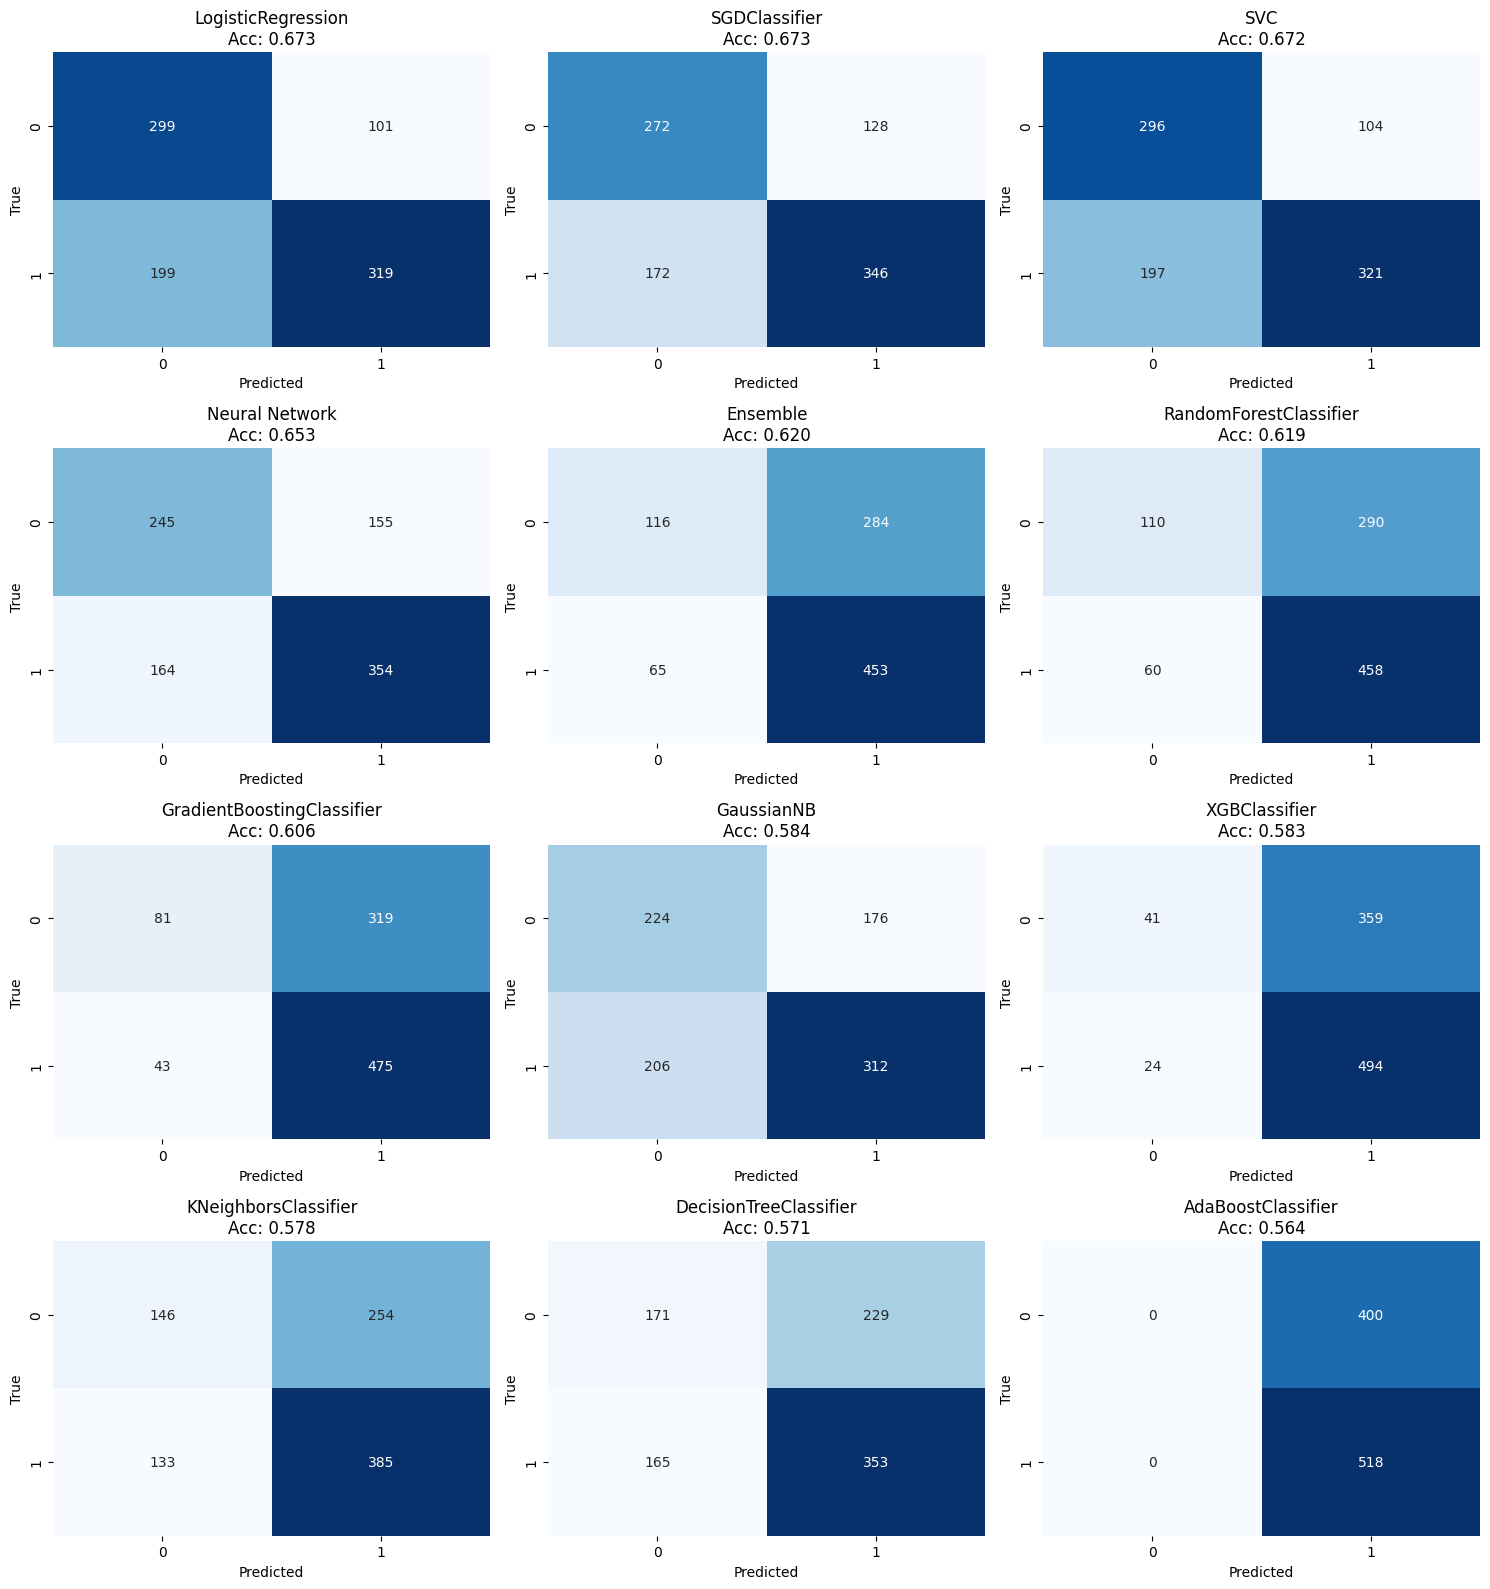

In [28]:
plot_all_confusion_matrices(accuracies, X_test, y_test, X_test_torch, y_test_torch, cols=3)


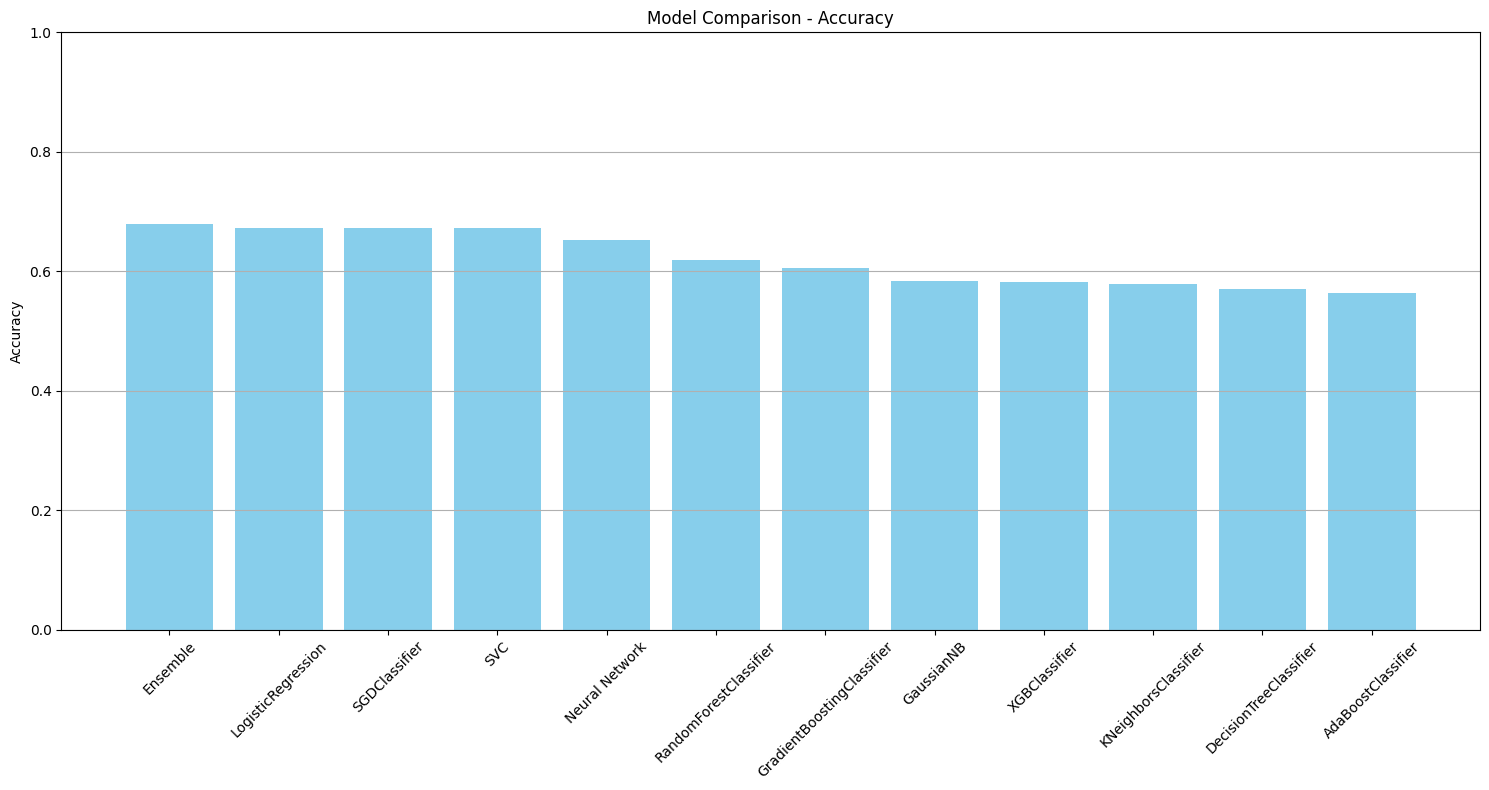

In [29]:
# Bar plot for Accuracy
plt.figure(figsize=(15, 8))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color='skyblue')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

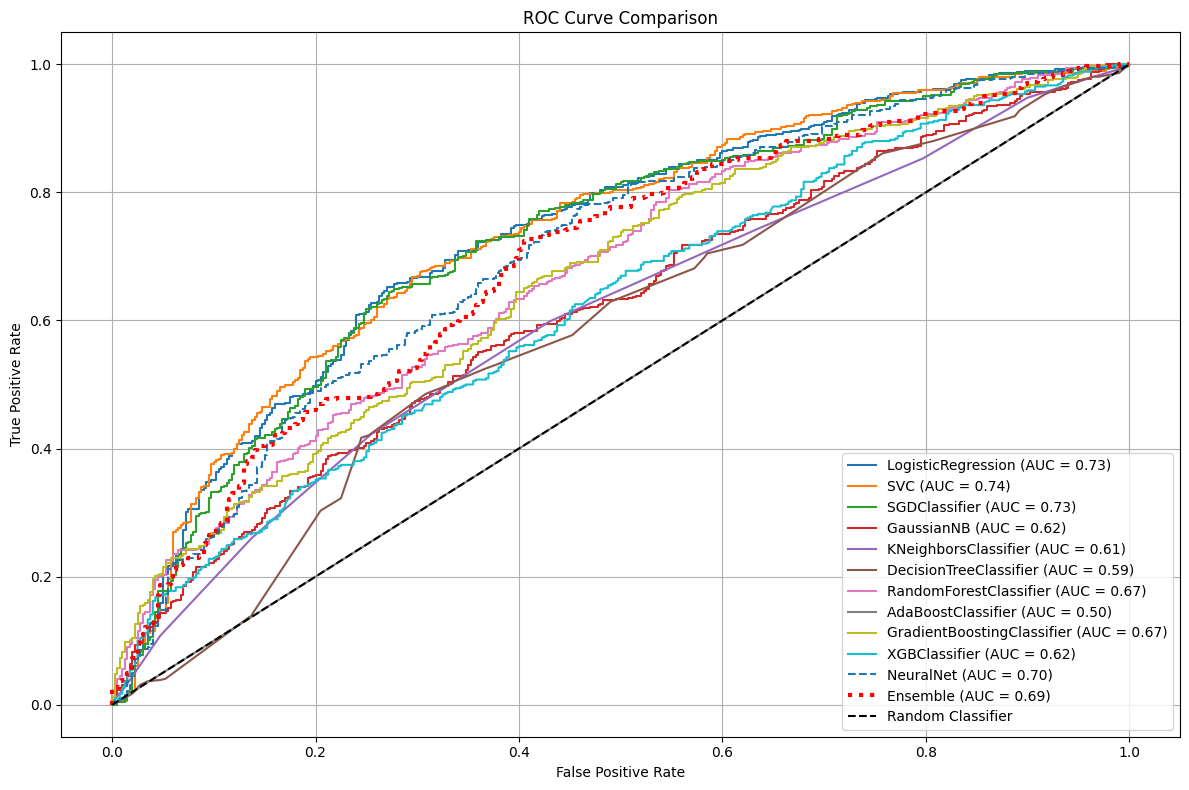

In [30]:
plt.figure(figsize=(12, 8))

# Loop through sklearn models
for name, grid in best_models.items():
    model = grid.best_estimator_
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# NN model (PyTorch)
pytorch_model.eval()
with torch.no_grad():
    y_logits = pytorch_model(X_test_torch)  # X_test is on CUDA
    y_probs = torch.sigmoid(y_logits).squeeze().cpu().numpy()  # move to CPU
    y_true = y_test_torch.squeeze().cpu().numpy()  # move to CPU
fpr_nn, tpr_nn, _ = roc_curve(y_true, y_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, label=f"NeuralNet (AUC = {roc_auc_nn:.2f})", linestyle='--')

# Ensemble model - get probabilities for ROC curve (using your existing selected_sklearn_models)
def ensemble_predict_proba(best_models_dict, pytorch_model, X, X_torch=None, selected_models=None, include_pytorch=True):
    """Get ensemble probabilities (average of all model probabilities)"""
    probabilities = []
    
    # Get probabilities from selected sklearn models
    if selected_models is None:
        models_to_use = best_models_dict.items()
    else:
        models_to_use = [(name, grid) for name, grid in best_models_dict.items() if name in selected_models]
    
    for name, grid in models_to_use:
        model = grid.best_estimator_
        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X)
            prob = 1 / (1 + np.exp(-scores))  # Sigmoid transformation
        else:
            prob = model.predict(X).astype(float)
        probabilities.append(prob)
    
    # Get probabilities from PyTorch model if requested
    if include_pytorch and pytorch_model is not None and X_torch is not None:
        pytorch_model.eval()
        device = next(pytorch_model.parameters()).device
        with torch.no_grad():
            logits = pytorch_model(X_torch.to(device)).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            probabilities.append(probs)
    
    # Return average probability
    if probabilities:
        return np.mean(probabilities, axis=0)
    else:
        raise ValueError("No models available for ensemble")

# Get ensemble probabilities and plot ROC curve (using your existing selected_sklearn_models)
ensemble_proba = ensemble_predict_proba(best_models, pytorch_model, X_test, X_test_torch, 
                                    selected_models=selected_sklearn_models, include_pytorch=True)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_proba)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
plt.plot(fpr_ensemble, tpr_ensemble, label=f"Ensemble (AUC = {roc_auc_ensemble:.2f})", 
        linestyle=':', linewidth=3, color='red')

# Final plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
def get_feature_importance(model, X, y, feature_names):
    """
    Returns a DataFrame of feature importance for any fitted classifier.
    
    Parameters:
        model: trained classifier
        X: features (DataFrame or numpy array)
        y: target
        feature_names: list of feature names
    
    Returns:
        Pandas DataFrame sorted by importance
    """

    importance = []

    # Case 1: Tree-based models
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_

    # Case 2: Linear models (LogisticRegression, SGDClassifier, LinearSVC, etc.)
    elif hasattr(model, "coef_"):
        importance = np.abs(model.coef_[0])  # take abs to get magnitude

    # Case 3: Models without built-in importance → use permutation importance
    else:
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        importance = result.importances_mean

    # Create DataFrame
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

    return importance_df

# Collect feature importances from all models
importance_dfs = []

for name, grid in best_models.items():
    model = grid.best_estimator_
    imp_df = get_feature_importance(model, X_train, y_train, feature_names=X_train.columns)
    imp_df = imp_df.set_index("Feature")
    imp_df.rename(columns={"Importance": name}, inplace=True)
    importance_dfs.append(imp_df)

# Combine all into one DataFrame, joining on feature names
combined_importance_df = pd.concat(importance_dfs, axis=1)

combined_importance_df


,LogisticRegression,SVC,SGDClassifier,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,XGBClassifier
Feature,,,,,,,,,,
fight_time_avg_diff,0.472470,0.663577,0.516803,0.006972,0.015033,0.117352,0.048880,0.0,0.108863,0.065009
year,0.408664,0.413090,0.356553,0.025245,0.013480,0.184088,0.110701,1.0,0.321605,0.194021
sig_strikes_landed_per_minute_diff,0.385667,0.514685,0.458491,0.011792,0.005910,0.045636,0.033549,0.0,0.093520,0.051990
knockdown_avg_diff,0.233040,0.365151,0.251287,0.004493,0.005174,0.019651,0.020093,0.0,0.026176,0.032159
sig_strikes_absorbed_per_minute_diff,0.210528,0.236880,0.171747,0.003350,0.005692,0.013505,0.008208,0.0,0.013517,0.031984
...,...,...,...,...,...,...,...,...,...,...
wins_last_365_days_diff,0.005730,0.032069,0.000000,0.005447,0.004521,0.000000,0.008147,0.0,0.012394,0.042516
avg_clinch_attempts_diff,0.005272,0.083376,0.000000,0.001634,0.003186,0.005469,0.012877,0.0,0.002312,0.000000
control_time_roll_5_diff,0.004262,0.031867,0.000000,0.001253,0.003785,0.007951,0.016328,0.0,0.025612,0.038042


In [32]:
def get_pytorch_feature_importance(model, X, y, feature_names=None, n_repeats=5, metric=accuracy_score):
    """
    Compute permutation feature importance for a PyTorch model.
    
    Parameters:
        model: trained PyTorch model (in eval mode)
        X: torch.Tensor of shape (n_samples, n_features), on correct device
        y: torch.Tensor of shape (n_samples,), binary labels (0/1)
        feature_names: list of feature names, or None
        n_repeats: number of shuffles per feature
        metric: function to evaluate model performance (default accuracy)
        
    Returns:
        Pandas DataFrame with features and mean importance (performance drop)
    """
    model.eval()
    baseline_preds = torch.sigmoid(model(X)).squeeze().detach().cpu().numpy() >= 0.5
    baseline_score = metric(y.cpu().numpy(), baseline_preds)
    
    importances = []
    X = X.clone()  # don't modify original

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            # Permute the i-th feature column
            idx = torch.randperm(X_permuted.size(0))
            X_permuted[:, i] = X_permuted[idx, i]
            
            with torch.no_grad():
                preds = torch.sigmoid(model(X_permuted)).squeeze().cpu().numpy() >= 0.5
            score = metric(y.cpu().numpy(), preds)
            scores.append(score)
        
        # Importance = drop in performance after permuting feature i
        mean_score = np.mean(scores)
        importances.append(baseline_score - mean_score)
    
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)
    
    return importance_df

feature_names = X_train.columns.tolist()

importance_df = get_pytorch_feature_importance(
    pytorch_model,
    X_train_torch,  # already on device, tensor shape (n_samples, n_features)
    y_train_torch,  # tensor shape (n_samples,)
    feature_names=feature_names,
    n_repeats=10
)

importance_df

,Feature,Importance
0,fight_time_avg_diff,0.043981
1,sig_strikes_landed_per_minute_diff,0.040033
2,year,0.034995
3,sig_strikes_absorbed_per_minute_diff,0.017184
4,knockdown_avg_diff,0.016394
...,...,...
57,head_strikes_ema_diff,0.003867
58,avg_distance_attempts_diff,0.003350
59,control_time_roll_5_diff,0.003159
60,win_streak_diff,0.002914


In [33]:
# Assuming combined_importance_df is your existing DataFrame with sklearn model importances
# and importance_df is the one returned by get_pytorch_feature_importance

# Set 'Feature' as index for the PyTorch importance df
importance_df = importance_df.set_index("Feature")

# Rename the Importance column to "Neural Network"
importance_df.rename(columns={"Importance": "Neural Network"}, inplace=True)

# Merge with combined_importance_df on the index (Feature names)
combined_importance_df = combined_importance_df.join(importance_df, how='outer')

# Optionally, recompute mean importance including the new model
combined_importance_df["Mean Importance"] = combined_importance_df.mean(axis=1)

# Sort by mean importance descending
combined_importance_df = combined_importance_df.sort_values(by="Mean Importance", ascending=False)

combined_importance_df


,LogisticRegression,SVC,SGDClassifier,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,XGBClassifier,Neural Network,Mean Importance
Feature,,,,,,,,,,,,
year,0.408664,0.413090,0.356553,0.025245,0.013480,0.184088,0.110701,1.0,0.321605,0.194021,0.034995,0.278404
fight_time_avg_diff,0.472470,0.663577,0.516803,0.006972,0.015033,0.117352,0.048880,0.0,0.108863,0.065009,0.043981,0.187176
sig_strikes_landed_per_minute_diff,0.385667,0.514685,0.458491,0.011792,0.005910,0.045636,0.033549,0.0,0.093520,0.051990,0.040033,0.149207
knockdown_avg_diff,0.233040,0.365151,0.251287,0.004493,0.005174,0.019651,0.020093,0.0,0.026176,0.032159,0.016394,0.088511
sig_strikes_absorbed_per_minute_diff,0.210528,0.236880,0.171747,0.003350,0.005692,0.013505,0.008208,0.0,0.013517,0.031984,0.017184,0.064781
...,...,...,...,...,...,...,...,...,...,...,...,...
knockdowns_roll_5_diff,0.006036,0.049581,0.000000,0.002832,0.004085,0.000000,0.006617,0.0,0.001611,0.000000,0.007898,0.007151
total_fights_before_diff,0.002096,0.021083,0.000000,0.005828,0.004085,0.000000,0.015498,0.0,0.009923,0.000000,0.007516,0.006003
takedowns_roll_5_diff,0.017836,0.009912,0.000000,0.002887,-0.000354,0.000000,0.012688,0.0,0.005594,0.000000,0.009586,0.005286


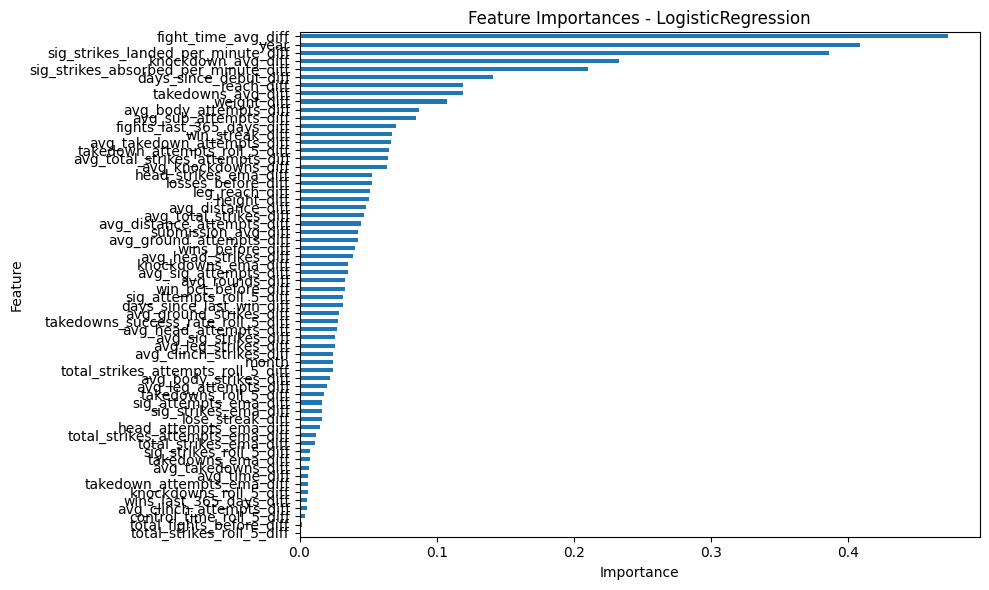

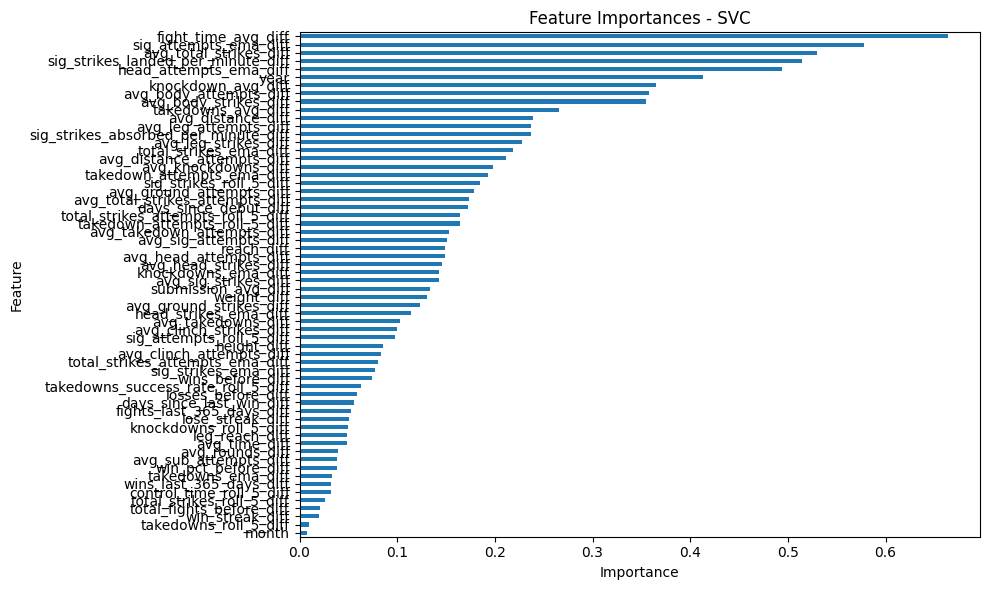

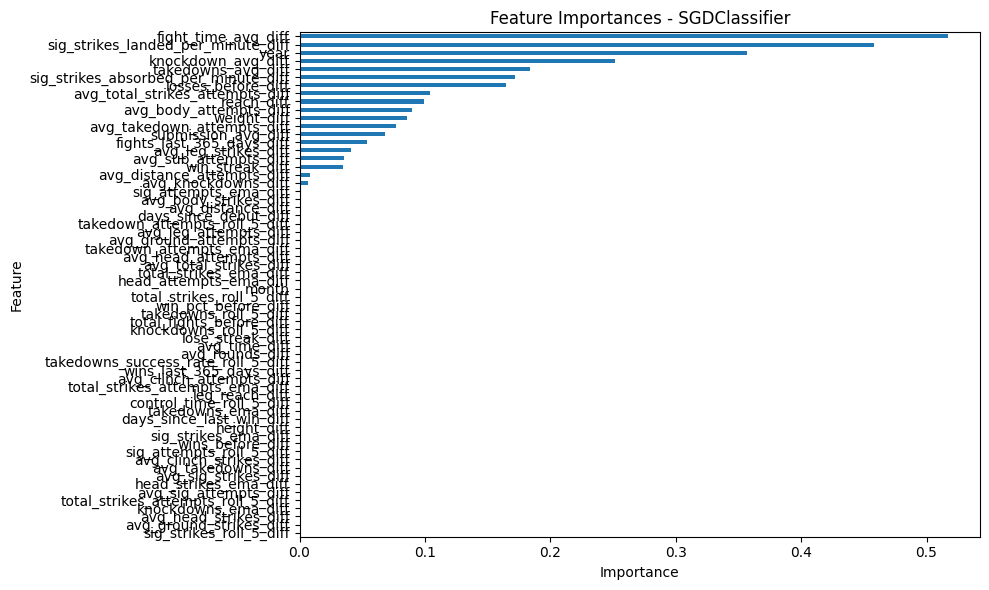

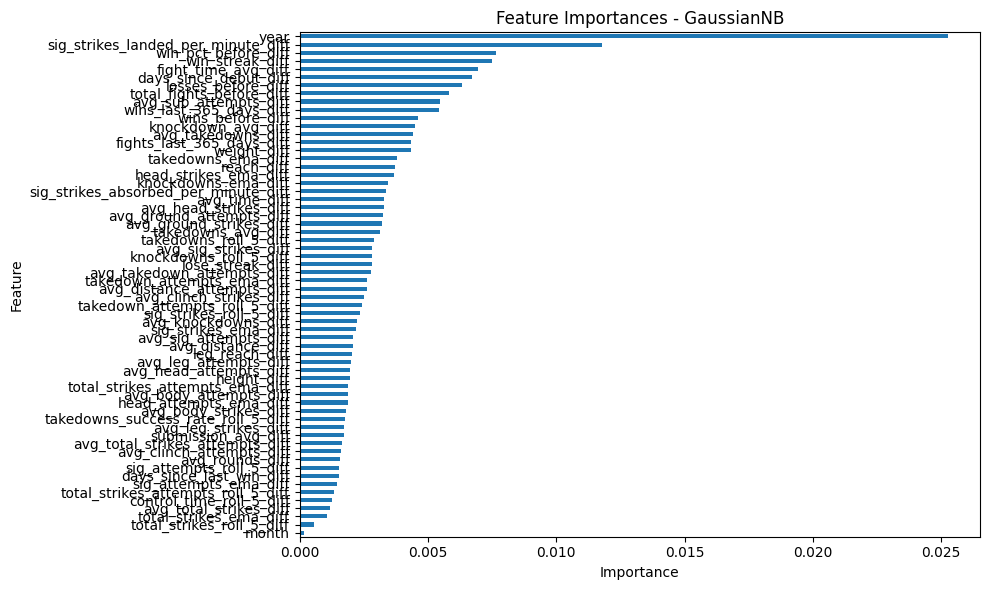

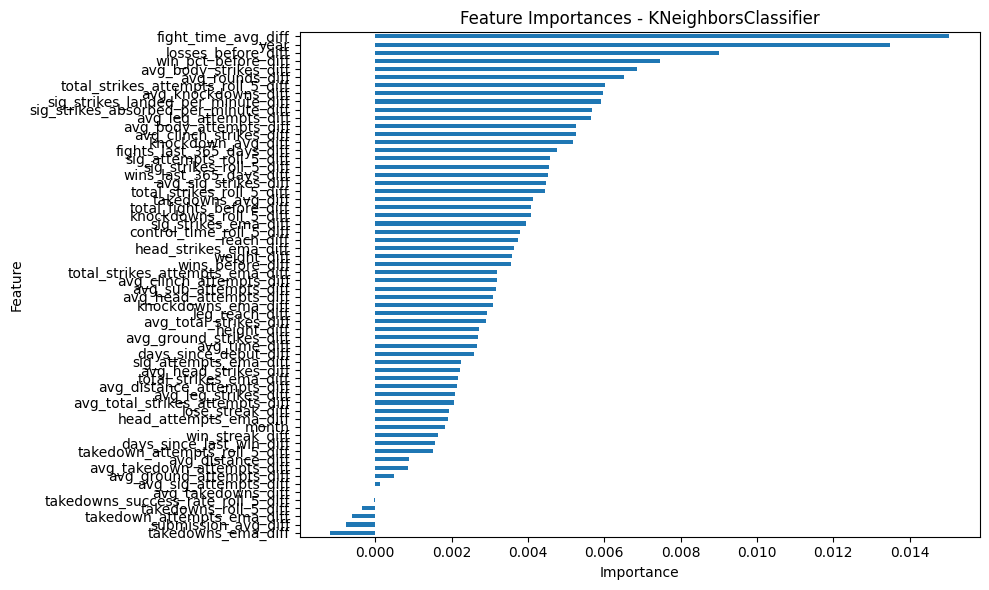

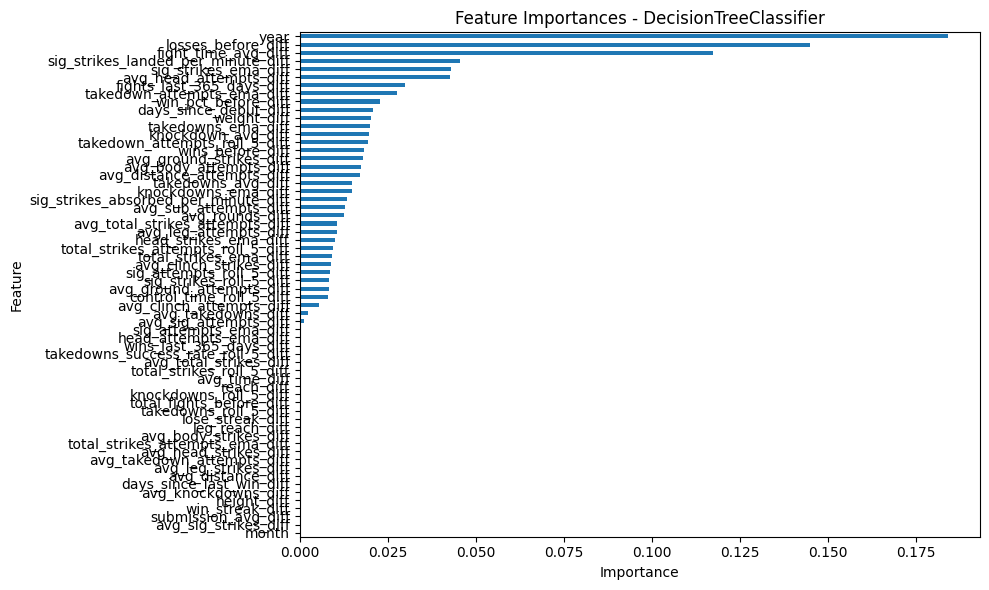

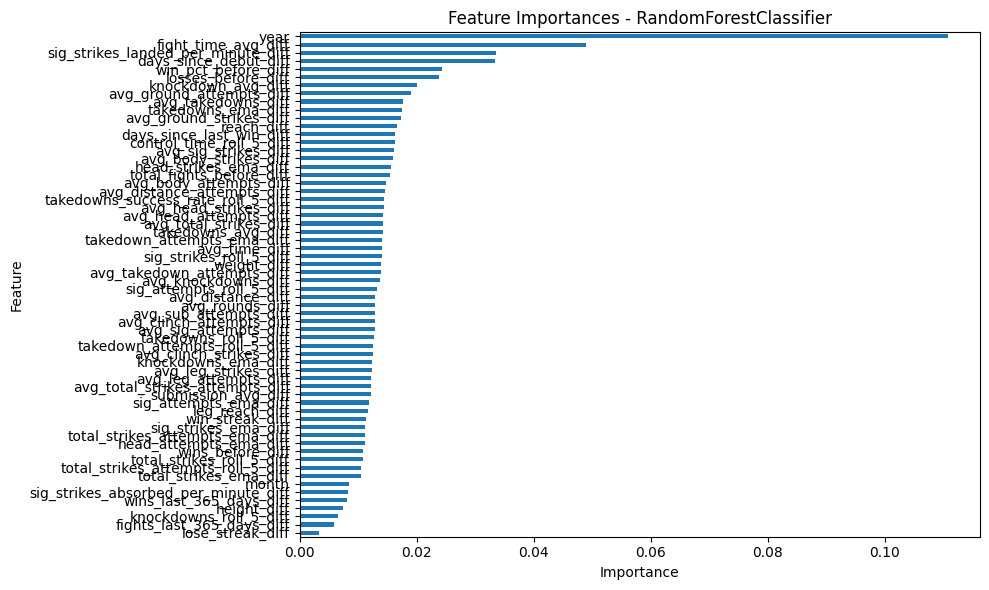

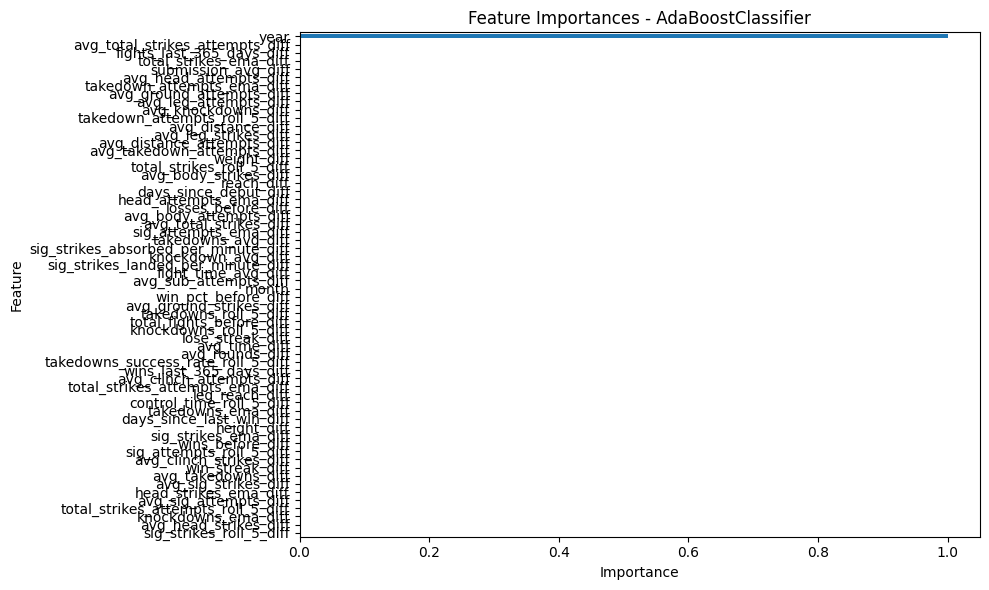

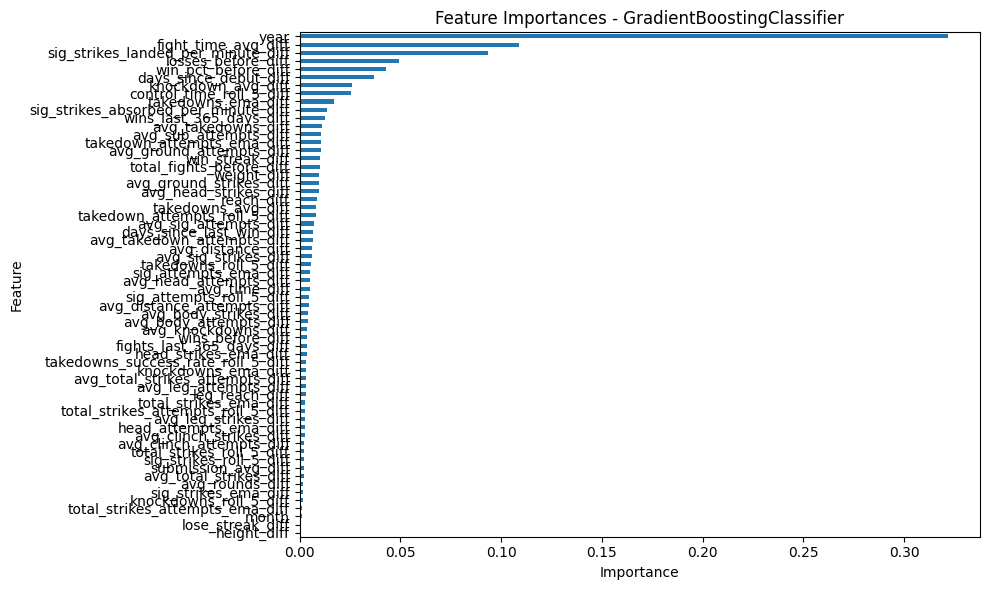

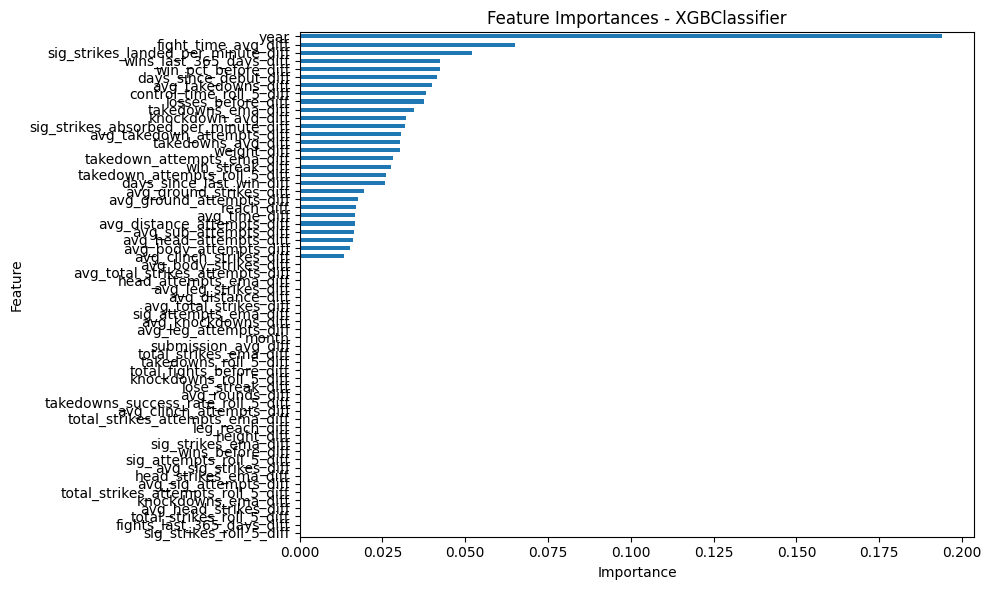

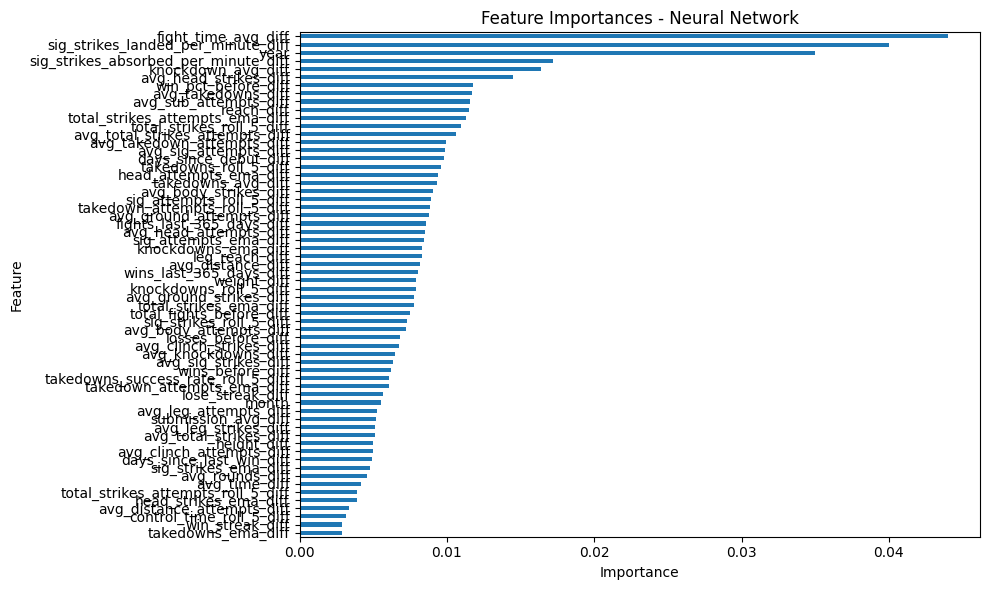

In [34]:
# Exclude 'Mean Importance' from the columns to plot
model_columns = [col for col in combined_importance_df.columns if col != "Mean Importance"]

for model_name in model_columns:
    plt.figure(figsize=(10, 6))
    combined_importance_df[model_name].sort_values(ascending=True).plot(kind='barh')
    plt.title(f'Feature Importances - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


Save the models

In [35]:
# Function to clean filename
def clean_filename(name):
    # Replace spaces and special characters with underscores
    cleaned = re.sub(r'[^\w\s-]', '', name)  # Remove special chars except spaces and hyphens
    cleaned = re.sub(r'[-\s]+', '_', cleaned)  # Replace spaces and hyphens with underscores
    return cleaned.lower()

# Save each model
saved_models = {}
for name, grid in best_models.items():
    best_model = grid.best_estimator_
    
    # Clean the model name for filename
    clean_name = clean_filename(name)
    filename = f"../models/{clean_name}.pkl"
    
    # Save the model
    with open(filename, 'wb') as f:
        pickle.dump(best_model, f)
    
    # Keep track of original name to filename mapping
    saved_models[name] = filename
    
    print(f"Saved '{name}' model to {filename}")

# Save PyTorch model
if 'pytorch_model' in locals() or 'pytorch_model' in globals():
    torch.save(pytorch_model.state_dict(), "../models/PyTorch_state_dict.pth")
    print(f"Saved PyTorch state dict to ../models/PyTorch_state_dict.pth")

Saved 'LogisticRegression' model to ../models/logisticregression.pkl
Saved 'SVC' model to ../models/svc.pkl
Saved 'SGDClassifier' model to ../models/sgdclassifier.pkl
Saved 'GaussianNB' model to ../models/gaussiannb.pkl
Saved 'KNeighborsClassifier' model to ../models/kneighborsclassifier.pkl
Saved 'DecisionTreeClassifier' model to ../models/decisiontreeclassifier.pkl
Saved 'RandomForestClassifier' model to ../models/randomforestclassifier.pkl
Saved 'AdaBoostClassifier' model to ../models/adaboostclassifier.pkl
Saved 'GradientBoostingClassifier' model to ../models/gradientboostingclassifier.pkl
Saved 'XGBClassifier' model to ../models/xgbclassifier.pkl
Saved PyTorch state dict to ../models/PyTorch_state_dict.pth
